In [ ]:
pip install pyvi

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding,Dense,Dropout,Bidirectional,LSTM,GRU,Input,GlobalMaxPooling1D,LayerNormalization,Conv1D,MaxPooling1D
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pyvi import ViTokenizer
from pyvi import ViUtils

# **Create input and label **

In [ ]:
data_path="comments_status.csv"
data=pd.read_csv(data_path)
data.head()

,content,status,product_id
0,Mình đã đọc hết cuốn búp sen xanh từ hổi lên l...,Tích cực,277875592.0
1,Vì nghe thông tin ngày 10/5 phát hành sẽ chuyể...,Trung tính,277875592.0
2,"Không có gì để chê, hơi tiếc là bản này không ...",Tích cực,277875592.0
3,"Bìa sách cứng, ánh kim rất đẹp. Bé nhà mình lớ...",Tích cực,277875592.0
4,Đã đọc bản thường rồi nên giờ mua bản đặc biệt...,Tích cực,277875592.0


# **Create input and label **

In [ ]:
sentiment_data=pd.DataFrame(data,columns=["content","status"])
sentiment_data=sentiment_data.dropna()
sentiment_data=sentiment_data.drop_duplicates(subset=["content"])
sentiment_data=sentiment_data.reset_index(drop=True)
print(sentiment_data.head())
print("sentiment_data shape: ", sentiment_data.shape)


                                             content      status
0  Mình đã đọc hết cuốn búp sen xanh từ hổi lên l...    Tích cực
1  Vì nghe thông tin ngày 10/5 phát hành sẽ chuyể...  Trung tính
2  Không có gì để chê, hơi tiếc là bản này không ...    Tích cực
3  Bìa sách cứng, ánh kim rất đẹp. Bé nhà mình lớ...    Tích cực
4  Đã đọc bản thường rồi nên giờ mua bản đặc biệt...    Tích cực
sentiment_data shape:  (41118, 2)


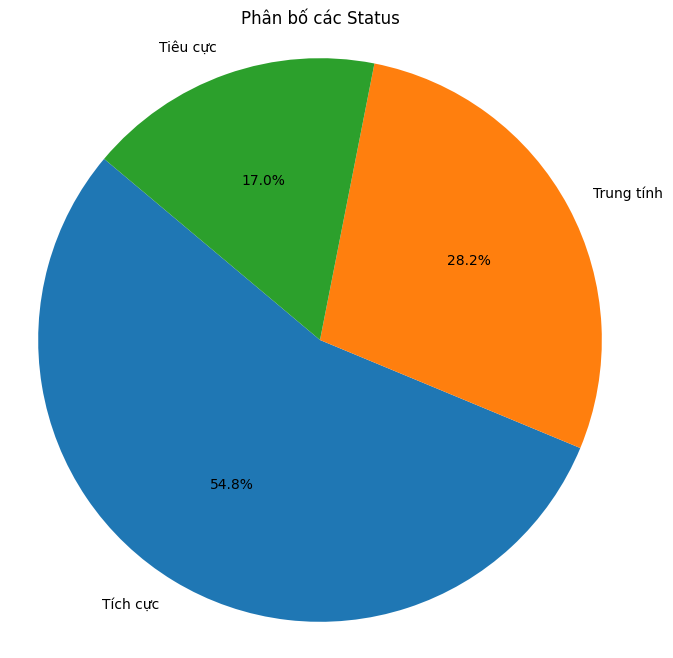

In [ ]:
import matplotlib.pyplot as plt
status_counts = sentiment_data['status'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Phân bố các Status')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [ ]:
input_data=sentiment_data["content"].values
input_label=sentiment_data["status"].values
label_data={"Tích cực":1,"Trung tính":0,"Tiêu cực":2}

input_pre=[]
label_with_accent=[]
for idx,dt in enumerate(input_data):
    input_text_pre=list(tf.keras.preprocessing.text.text_to_word_sequence(dt))
    input_text_pre=" ".join(input_text_pre)
    input_text_pre_no_accent=str(ViUtils.remove_accents(input_text_pre).decode("utf-8"))
    input_text_pre_accent=ViTokenizer.tokenize(input_text_pre)
    input_text_pre_no_accent=ViTokenizer.tokenize(input_text_pre_no_accent)
    input_pre.append(input_text_pre_accent)
    input_pre.append(input_text_pre_no_accent)
    label_with_accent.append(input_label[idx])
    label_with_accent.append(input_label[idx])
print("label size: ", len(input_label))
print("label size: ", len(input_pre))


label size:  41118
label size:  82236


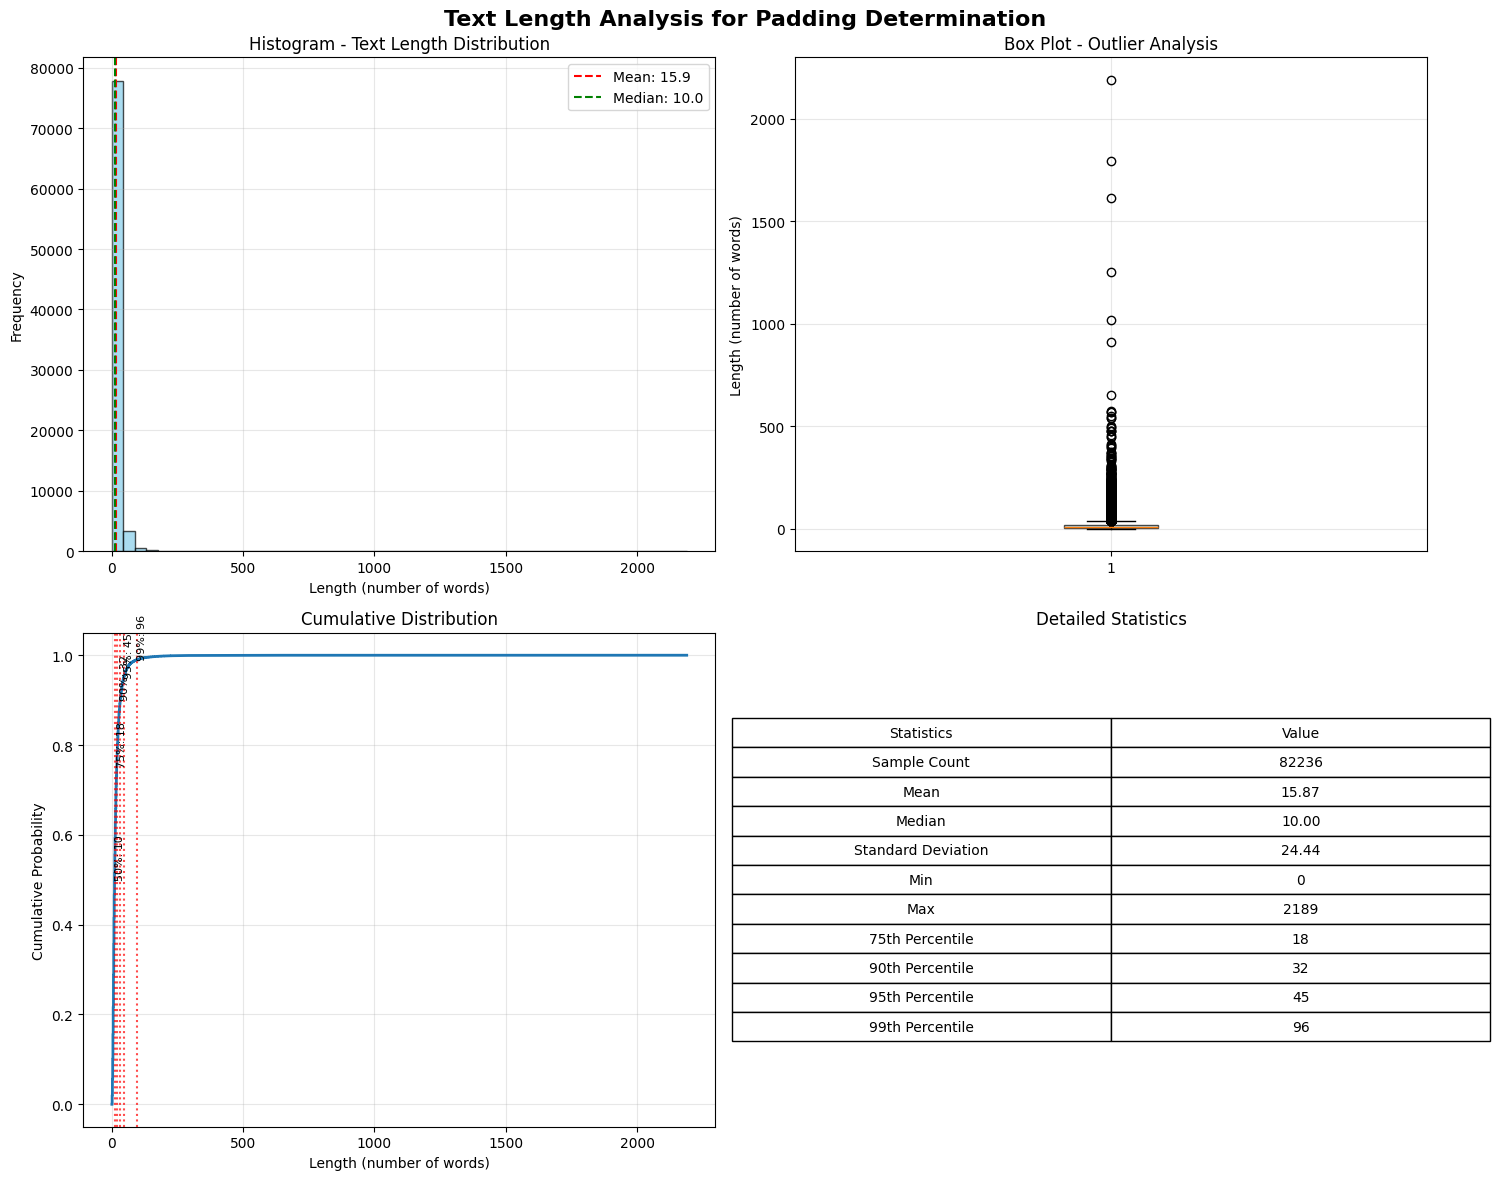

PADDING RECOMMENDATIONS FOR TRAINING:
Average length: 15.9 words
Median length: 10.0 words

Suggested padding options:
- Padding = 18: Covers 75% of data
- Padding = 32: Covers 90% of data (Recommended)
- Padding = 45: Covers 95% of data
- Padding = 96: Covers 99% of data

Notes:
- Too small padding: Loss of important information
- Too large padding: Increased training time and memory usage
- Usually choosing padding at 90-95% percentile is reasonable

Phân tích Outliers:
- Ngưỡng outlier (Q3 + 1.5*IQR): 36.0
- Số lượng outliers: 6328 (7.7%)
- Độ dài outliers: min=37, max=2189


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns



lengths = [len(text.split()) for text in input_pre]


fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Text Length Analysis for Padding Determination', fontsize=16, fontweight='bold')


axes[0, 0].hist(lengths, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Histogram - Text Length Distribution')
axes[0, 0].set_xlabel('Length (number of words)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(True, alpha=0.3)


mean_length = np.mean(lengths)
median_length = np.median(lengths)
axes[0, 0].axvline(mean_length, color='red', linestyle='--', label=f'Mean: {mean_length:.1f}')
axes[0, 0].axvline(median_length, color='green', linestyle='--', label=f'Median: {median_length:.1f}')
axes[0, 0].legend()


axes[0, 1].boxplot(lengths, vert=True, patch_artist=True,
                   boxprops=dict(facecolor='lightblue', alpha=0.7))
axes[0, 1].set_title('Box Plot - Outlier Analysis')
axes[0, 1].set_ylabel('Length (number of words)')
axes[0, 1].grid(True, alpha=0.3)


sorted_lengths = np.sort(lengths)
cumulative_prob = np.arange(1, len(sorted_lengths) + 1) / len(sorted_lengths)
axes[1, 0].plot(sorted_lengths, cumulative_prob, linewidth=2)
axes[1, 0].set_title('Cumulative Distribution')
axes[1, 0].set_xlabel('Length (number of words)')
axes[1, 0].set_ylabel('Cumulative Probability')
axes[1, 0].grid(True, alpha=0.3)

percentiles = [50, 75, 90, 95, 99]
for p in percentiles:
    val = np.percentile(lengths, p)
    axes[1, 0].axvline(val, color='red', linestyle=':', alpha=0.7)
    axes[1, 0].text(val, p/100, f'{p}%: {val:.0f}', rotation=90,
                    verticalalignment='bottom', fontsize=8)

stats_data = [
    ['Sample Count', len(lengths)],
    ['Mean', f'{mean_length:.2f}'],
    ['Median', f'{median_length:.2f}'],
    ['Standard Deviation', f'{np.std(lengths):.2f}'],
    ['Min', f'{min(lengths)}'],
    ['Max', f'{max(lengths)}'],
    ['75th Percentile', f'{np.percentile(lengths, 75):.0f}'],
    ['90th Percentile', f'{np.percentile(lengths, 90):.0f}'],
    ['95th Percentile', f'{np.percentile(lengths, 95):.0f}'],
    ['99th Percentile', f'{np.percentile(lengths, 99):.0f}']
]

axes[1, 1].axis('tight')
axes[1, 1].axis('off')
table = axes[1, 1].table(cellText=stats_data,
                        colLabels=['Statistics', 'Value'],
                        cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)
axes[1, 1].set_title('Detailed Statistics')

plt.tight_layout()
plt.show()


print("="*60)
print("PADDING RECOMMENDATIONS FOR TRAINING:")
print("="*60)
print(f"Average length: {mean_length:.1f} words")
print(f"Median length: {median_length:.1f} words")
print()
print("Suggested padding options:")
print(f"- Padding = {int(np.percentile(lengths, 75))}: Covers 75% of data")
print(f"- Padding = {int(np.percentile(lengths, 90))}: Covers 90% of data (Recommended)")
print(f"- Padding = {int(np.percentile(lengths, 95))}: Covers 95% of data")
print(f"- Padding = {int(np.percentile(lengths, 99))}: Covers 99% of data")
print()
print("Notes:")
print("- Too small padding: Loss of important information")
print("- Too large padding: Increased training time and memory usage")
print("- Usually choosing padding at 90-95% percentile is reasonable")


q1 = np.percentile(lengths, 25)
q3 = np.percentile(lengths, 75)
iqr = q3 - q1
outlier_threshold = q3 + 1.5 * iqr
outliers = [x for x in lengths if x > outlier_threshold]

print(f"\nPhân tích Outliers:")
print(f"- Ngưỡng outlier (Q3 + 1.5*IQR): {outlier_threshold:.1f}")
print(f"- Số lượng outliers: {len(outliers)} ({len(outliers)/len(lengths)*100:.1f}%)")
if outliers:
    print(f"- Độ dài outliers: min={min(outliers)}, max={max(outliers)}")

In [ ]:
label_idx=[label_data[i] for i in label_with_accent]
# to_categorical  ( one-hot encoding.)
label_tf=tf.keras.utils.to_categorical(label_idx,num_classes=3)

tokenizer_data=Tokenizer(oov_token="<OOV>",filters='',split =' ')
tokenizer_data.fit_on_texts(input_pre)
tokenizer_data_text=tokenizer_data.texts_to_sequences(input_pre)
vec_data=pad_sequences(tokenizer_data_text,maxlen=60,padding="post")
print(" vec_data shape: ", vec_data.shape)
data_voca_size=len(tokenizer_data.word_index)+1
print("data_voca_size: ",data_voca_size)
print("label size: ", len(label_with_accent))



 vec_data shape:  (82236, 60)
data_voca_size:  20654
label size:  82236


# **split data**

In [ ]:
X_train,X_val,y_train,y_val=train_test_split(vec_data,label_tf,test_size=0.2,random_state=42)
X_train,X_test,y_train,y_test=train_test_split(X_train,y_train,test_size=0.1,random_state=42)
print("X_train shape: ", X_train.shape)
print("X_val shape: ", X_val.shape)
print("X_test shape: ", X_test.shape)
print(X_train)

X_train shape:  (59209, 60)
X_val shape:  (16448, 60)
X_test shape:  (6579, 60)
[[  4  35   2 ...   0   0   0]
 [ 38 336  64 ...   0   0   0]
 [606 735  10 ...   0   0   0]
 ...
 [271 212 106 ...   0   0   0]
 [  8  13  52 ...   0   0   0]
 [390 526 296 ...   0   0   0]]


# **Create Model **

In [ ]:
def generate_model():
  dropout_threshold=0.4
  input_dim=data_voca_size
  output_dim=32 #co the sua
  input_length=60
  initializer=tf.keras.initializers.GlorotUniform()

  input_layer=Input(shape=(input_length,))
  feature=Embedding(input_dim=input_dim,output_dim=output_dim,input_length=input_length,embeddings_initializer="GlorotUniform")(input_layer)

  # CNN Branch
  cnn_feature=Conv1D(filters=32,kernel_size=3,padding="same",activation="relu")(feature)
  cnn_feature=MaxPooling1D()(cnn_feature)
  cnn_feature=Dropout(dropout_threshold)(cnn_feature)
  cnn_feature=Conv1D(filters=32,kernel_size=3,padding="same",activation="relu")(cnn_feature)
  cnn_feature=MaxPooling1D()(cnn_feature)
  cnn_feature=LayerNormalization()(cnn_feature)
  cnn_feature=Dropout(dropout_threshold)(cnn_feature)
  cnn_feature_pooled = GlobalMaxPooling1D()(cnn_feature)
  print(cnn_feature.shape)
  print(cnn_feature_pooled.shape)


  # RNN Branch
  bi_lstm_feature=Bidirectional(LSTM(units=32,dropout=dropout_threshold ,return_sequences=True,kernel_initializer=initializer),merge_mode='concat')(feature)
  bi_lstm_feature=MaxPooling1D()(bi_lstm_feature)

  bi_lstm_feature=Bidirectional(GRU(units=32,dropout=dropout_threshold ,return_sequences=True,kernel_initializer=initializer),merge_mode='concat')(feature)
  bi_lstm_feature=MaxPooling1D()(bi_lstm_feature)
  bi_lstm_feature=LayerNormalization()(bi_lstm_feature)
  bi_lstm_feature_pooled = GlobalMaxPooling1D()(bi_lstm_feature)
  print(bi_lstm_feature.shape)
  print(bi_lstm_feature_pooled.shape)

  combine_feature = tf.keras.layers.Concatenate()([cnn_feature_pooled, bi_lstm_feature_pooled])

  combine_feature = LayerNormalization()(combine_feature)

  classifier = Dense(90, activation='relu')(combine_feature)
  classifier = Dropout(0.2)(classifier)
  classifier = Dense(70, activation='relu')(classifier)
  classifier = Dropout(0.2)(classifier)
  classifier = Dense(50, activation='relu')(classifier)
  classifier = Dropout(0.2)(classifier)
  classifier = Dense(30, activation='relu')(classifier)
  classifier = Dropout(0.2)(classifier)
  classifier = Dense(3, activation='softmax')(classifier)

  model = tf.keras.Model(inputs=input_layer, outputs=classifier)
  return model

model=generate_model()
adam=Adam(learning_rate=0.001)
model.compile(optimizer=adam,loss="categorical_crossentropy",metrics=["accuracy"])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


(None, 15, 32)
(None, 32)
(None, 30, 64)
(None, 64)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 60)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 60, 32)    │    660,928 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 60, 32)    │      3,104 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 30, 32)    │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 30, 32)    │          0 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 30, 32)    │      3,104 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 15, 32)    │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 60, 64)    │     12,672 │ embedding[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 15, 32)    │         64 │ max_pooling1d_1[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 30, 64)    │          0 │ bidirectional_1[… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 15, 32)    │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 64)    │        128 │ max_pooling1d_3[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 32)        │          0 │ dropout_1[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 96)        │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 96)        │        192 │ concatenate[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 90)        │      8,730 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 90)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 70)        │      6,370 │ dropout_2[0][0] 

 Total params: 700,465 (2.67 MB)

 Trainable params: 700,465 (2.67 MB)

 Non-trainable params: 0 (0.00 B)

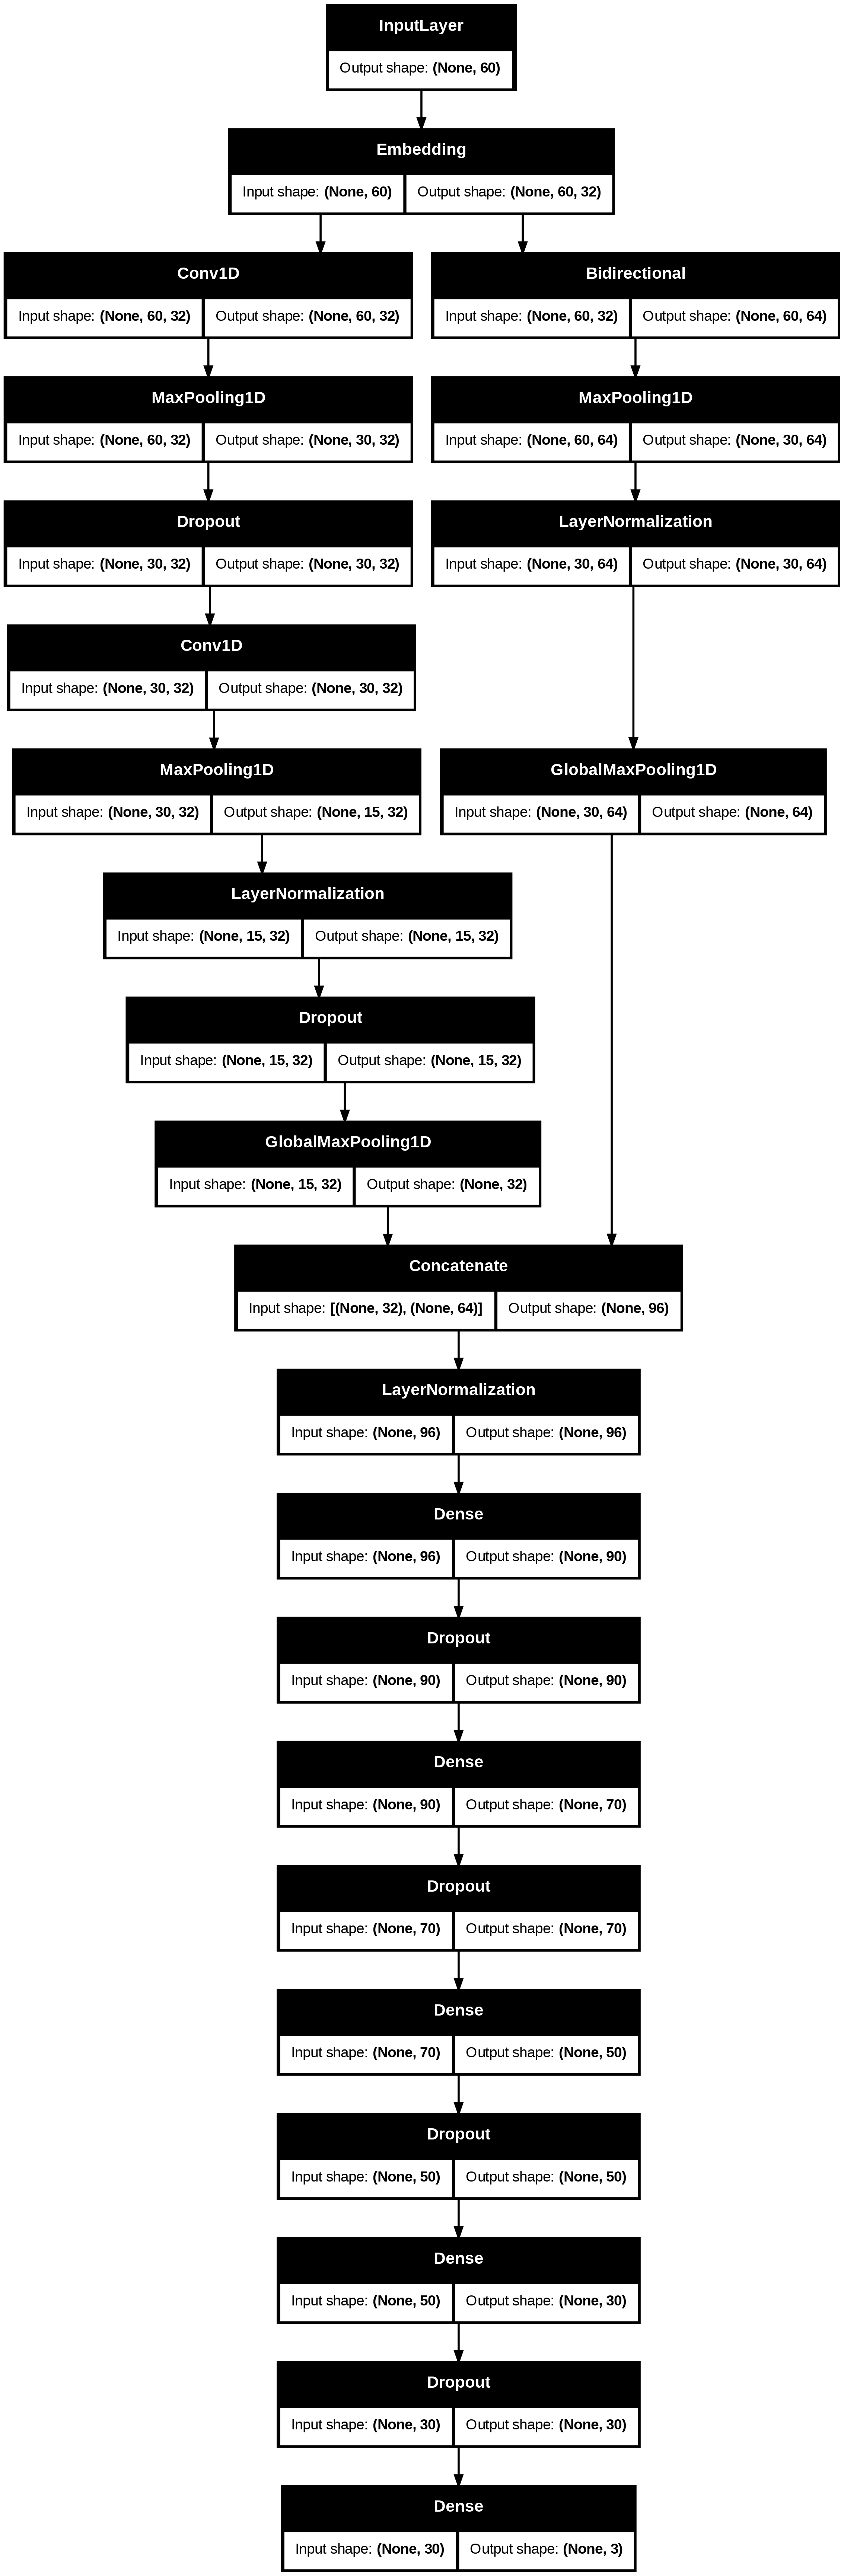

In [ ]:
dot_img_file = 'model_visualize.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [ ]:
callback_model=tf.keras.callbacks.ModelCheckpoint('model_cnn_bilstm.keras',monitor='val_loss')
history=model.fit(X_train,y_train,epochs=20,batch_size=32,validation_data=(X_val,y_val),callbacks=[callback_model])

Epoch 1/20
1851/1851 ━━━━━━━━━━━━━━━━━━━━ 145s 74ms/step - accuracy: 0.6239 - loss: 0.8131 - val_accuracy: 0.7234 - val_loss: 0.6381
Epoch 2/20
1851/1851 ━━━━━━━━━━━━━━━━━━━━ 139s 72ms/step - accuracy: 0.7533 - loss: 0.5942 - val_accuracy: 0.7622 - val_loss: 0.5697
Epoch 3/20
1851/1851 ━━━━━━━━━━━━━━━━━━━━ 137s 69ms/step - accuracy: 0.7829 - loss: 0.5321 - val_accuracy: 0.7624 - val_loss: 0.5703
Epoch 4/20
1851/1851 ━━━━━━━━━━━━━━━━━━━━ 145s 71ms/step - accuracy: 0.8024 - loss: 0.4949 - val_accuracy: 0.7723 - val_loss: 0.5937
Epoch 5/20
1851/1851 ━━━━━━━━━━━━━━━━━━━━ 140s 70ms/step - accuracy: 0.8209 - loss: 0.4544 - val_accuracy: 0.7713 - val_loss: 0.5949
Epoch 6/20
1851/1851 ━━━━━━━━━━━━━━━━━━━━ 147s 73ms/step - accuracy: 0.8257 - loss: 0.4397 - val_accuracy: 0.7734 - val_loss: 0.6697
Epoch 7/20
1851/1851 ━━━━━━━━━━━━━━━━━━━━ 138s 71ms/step - accuracy: 0.8355 - loss: 0.4168 - val_accuracy: 0.7735 - val_loss: 0.6335
Epoch 8/20
1851/1851 ━━━━━━━━━━━━━━━━━━━━ 147s 73ms/step - accuracy: 

In [ ]:
# prompt: print current version of tensorflow

tf.__version__

'2.18.0'

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pyvi import ViTokenizer
from pyvi import ViUtils

try:

    loaded_model = load_model('model_cnn_bilstm.keras')
    print("Đã tải mô hình thành công!")
except Exception as e:
    print(f"Lỗi khi tải mô hình: {e}")
    print("Hãy đảm bảo tệp mô hình tồn tại và đường dẫn đúng.")

    exit()


label_data={"Tích cực":1,"Trung tính":0,"Tiêu cực":2}
index_to_label = {v: k for k, v in label_data.items()}


print("\nNhập câu bạn muốn dự đoán cảm xúc. Gõ 'exit' để thoát.")


maxlen = 40

while True:
    sample_text = input("\nNhập câu: ")

    if sample_text.lower() == 'exit':
        print("Kết thúc chương trình.")
        break


    sample_processed = []


    sample_processed_accent = ViTokenizer.tokenize(sample_text)
    sample_processed.append(sample_processed_accent)

    try:
        sample_sequence = tokenizer_data.texts_to_sequences(sample_processed)
    except Exception as e:
        print(f"Lỗi trong quá trình tokenizer: {e}")
        print("Có thể câu nhập vào chứa từ mới không có trong từ điển huấn luyện.")
        continue



    sample_padded = pad_sequences(sample_sequence, maxlen=maxlen, padding="post")


    predictions = loaded_model.predict(sample_padded)


    predicted_classes_index = np.argmax(predictions, axis=1)

    print("Kết quả dự đoán:")
    for i, label_index in enumerate(predicted_classes_index):
        sentiment_label = index_to_label[label_index]

        if len(predicted_classes_index) == 1:
             print(f"- Nhãn dự đoán: {sentiment_label}")
             print(f"- Xác suất tương ứng: {predictions[0]}")


Đã tải mô hình thành công!

Nhập câu bạn muốn dự đoán cảm xúc. Gõ 'exit' để thoát.
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Kết quả dự đoán:
- Nhãn dự đoán: Tiêu cực
- Xác suất tương ứng: [1.4699683e-01 2.9217664e-04 8.5271102e-01]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Kết quả dự đoán:
- Nhãn dự đoán: Trung tính
- Xác suất tương ứng: [0.86761403 0.12249968 0.00988624]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Kết quả dự đoán:
- Nhãn dự đoán: Tích cực
- Xác suất tương ứng: [1.6533244e-04 9.9983466e-01 1.8236263e-11]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Kết quả dự đoán:
- Nhãn dự đoán: Tiêu cực
- Xác suất tương ứng: [1.0449202e-01 4.1926200e-05 8.9546609e-01]
